In [2]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, pearsonr, wilcoxon, gaussian_kde


In [3]:
#Define list of elements (promoters and enhancers)

elements = np.array([
    "F9",       #promoter
    "LDLR",     #promoter
    "SORT1",    #enhancer
    "GP1BA",    #promoter
    "HBB",      #promoter
    "HBG1",     #promoter
    "PKLR",     #promoter
    "HNF4A",    #promoter
    "MSMB",     #promoter
    "TERT",     #promoter
    "MYCrs6983267", #enhancer
    "ZFAND3",   #enhancer
    "IRF6",     #enhancer
    "IRF4",     #enhancer
], dtype=object)


In [4]:
#Load pre-calculated performance metrics for borzoi and enformer

data_strs = [
    'DNase, agnostic',
    'DNase, specific',
    'DNase + H3K, agnostic',
    'DNase + H3K, specific',
    'CAGE/RNA, agnostic',
    'CAGE/RNA, specific',
    'DNase + H3K + CAGE/RNA, agnostic',
    'DNase + H3K + CAGE/RNA, specific',
]

#Enformer

#05k
pearson_mat_enformer_05k = np.load('satmut_enformer_05k_pearson_opt.npy')
spearman_mat_enformer_05k = np.load('satmut_enformer_05k_spearman_opt.npy')

#4k
pearson_mat_enformer_4k = np.load('satmut_enformer_4k_pearson_opt.npy')
spearman_mat_enformer_4k = np.load('satmut_enformer_4k_spearman_opt.npy')

#Borzoi (ensemble)

#05k
pearson_mat_borzoi_05k = np.load('satmut_borzoi_05k_pearson_opt.npy')
spearman_mat_borzoi_05k = np.load('satmut_borzoi_05k_spearman_opt.npy')

#4k
pearson_mat_borzoi_4k = np.load('satmut_borzoi_4k_pearson_opt.npy')
spearman_mat_borzoi_4k = np.load('satmut_borzoi_4k_spearman_opt.npy')

#Borzoi (fold 0 only)

#05k
pearson_mat_borzoi_05k_f0 = np.load('satmut_borzoi_05k_pearson_opt_f0.npy')
spearman_mat_borzoi_05k_f0 = np.load('satmut_borzoi_05k_spearman_opt_f0.npy')

#4k
pearson_mat_borzoi_4k_f0 = np.load('satmut_borzoi_4k_pearson_opt_f0.npy')
spearman_mat_borzoi_4k_f0 = np.load('satmut_borzoi_4k_spearman_opt_f0.npy')


In [5]:

#Function to plot performance chart
def _plot_bar_chart(plot_title, subset_index, data_index, metric, window_size, model_names, model_assay_colors, bar_hatch=None, y_min=None, y_max=None, save_name=None) :
    
    #Filter data
    elements_curr = elements[subset_index]

    corr_enformer = None
    corr_borzoi = None
    corr_borzoi_f0 = None

    #Collect and filter scores
    if metric == 'spearman' :
        if window_size == '512bp' :
            corr_enformer = spearman_mat_enformer_05k[data_index, :][:, subset_index]
            corr_borzoi = spearman_mat_borzoi_05k[data_index, :][:, subset_index]
            corr_borzoi_f0 = spearman_mat_borzoi_05k_f0[data_index, :][:, subset_index]
        elif window_size == '4kb' :
            corr_enformer = spearman_mat_enformer_4k[data_index, :][:, subset_index]
            corr_borzoi = spearman_mat_borzoi_4k[data_index, :][:, subset_index]
            corr_borzoi_f0 = spearman_mat_borzoi_4k_f0[data_index, :][:, subset_index]
    elif metric == 'pearson' :
        if window_size == '512bp' :
            corr_enformer = pearson_mat_enformer_05k[data_index, :][:, subset_index]
            corr_borzoi = pearson_mat_borzoi_05k[data_index, :][:, subset_index]
            corr_borzoi_f0 = pearson_mat_borzoi_05k_f0[data_index, :][:, subset_index]
        elif window_size == '4kb' :
            corr_enformer = pearson_mat_enformer_4k[data_index, :][:, subset_index]
            corr_borzoi = pearson_mat_borzoi_4k[data_index, :][:, subset_index]
            corr_borzoi_f0 = pearson_mat_borzoi_4k_f0[data_index, :][:, subset_index]

    #Concatenate model scores
    corr = np.concatenate([
        corr_enformer[None, ...],
        corr_borzoi[None, ...],
        corr_borzoi_f0[None, ...],
    ], axis=0)
    
    #Plot barchart
    f = plt.figure(figsize=(10, 4.5), dpi=300)

    n_models = corr.shape[0] - 1
    n_assays = corr.shape[1]
    n_elements = corr.shape[2]

    elements_x = np.arange(n_elements)
    
    #Loop over models
    for model_i in range(n_models) :
        for assay_i in range(n_assays) :

            #Plot metrics
            plt.bar(
                elements_x * (n_models * n_assays + 0.5) + model_i * n_assays + assay_i,
                corr[model_i, assay_i, :],
                width=0.8,
                color=model_assay_colors[model_i][assay_i],
                label=model_names[model_i] + "; " + data_strs[data_index[assay_i]],
                hatch=bar_hatch,
                edgecolor='black',
                linewidth=0.5,
                zorder=0
            )
    
    #Add overlapping bars for Borzoi fold 0
    for assay_i in range(n_assays) :
        plt.bar(
            elements_x * (n_models * n_assays + 0.5) + (n_models - 1) * n_assays + assay_i,
            corr[n_models, assay_i, :],
            width=0.8,
            color=model_assay_colors[n_models][assay_i],
            #label=model_names[n_models] + "; " + data_strs[data_index[assay_i]],
            hatch="/",
            alpha=0.5,
            edgecolor='black',
            linewidth=0.5,
            zorder=1
        )

    plt.xticks(elements_x * (n_models * n_assays + 0.5) + n_models * n_assays / 2. - 0.5, elements_curr, fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.ylabel("Spearman R" if metric == 'spearman' else "Pearson R", fontsize=10)

    plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2, fancybox=True, shadow=True)

    plt.xlabel(plot_title, fontsize=10)

    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)

    plt.tight_layout()
    
    if save_name is not None :
        plt.savefig(save_name + ".eps")

    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


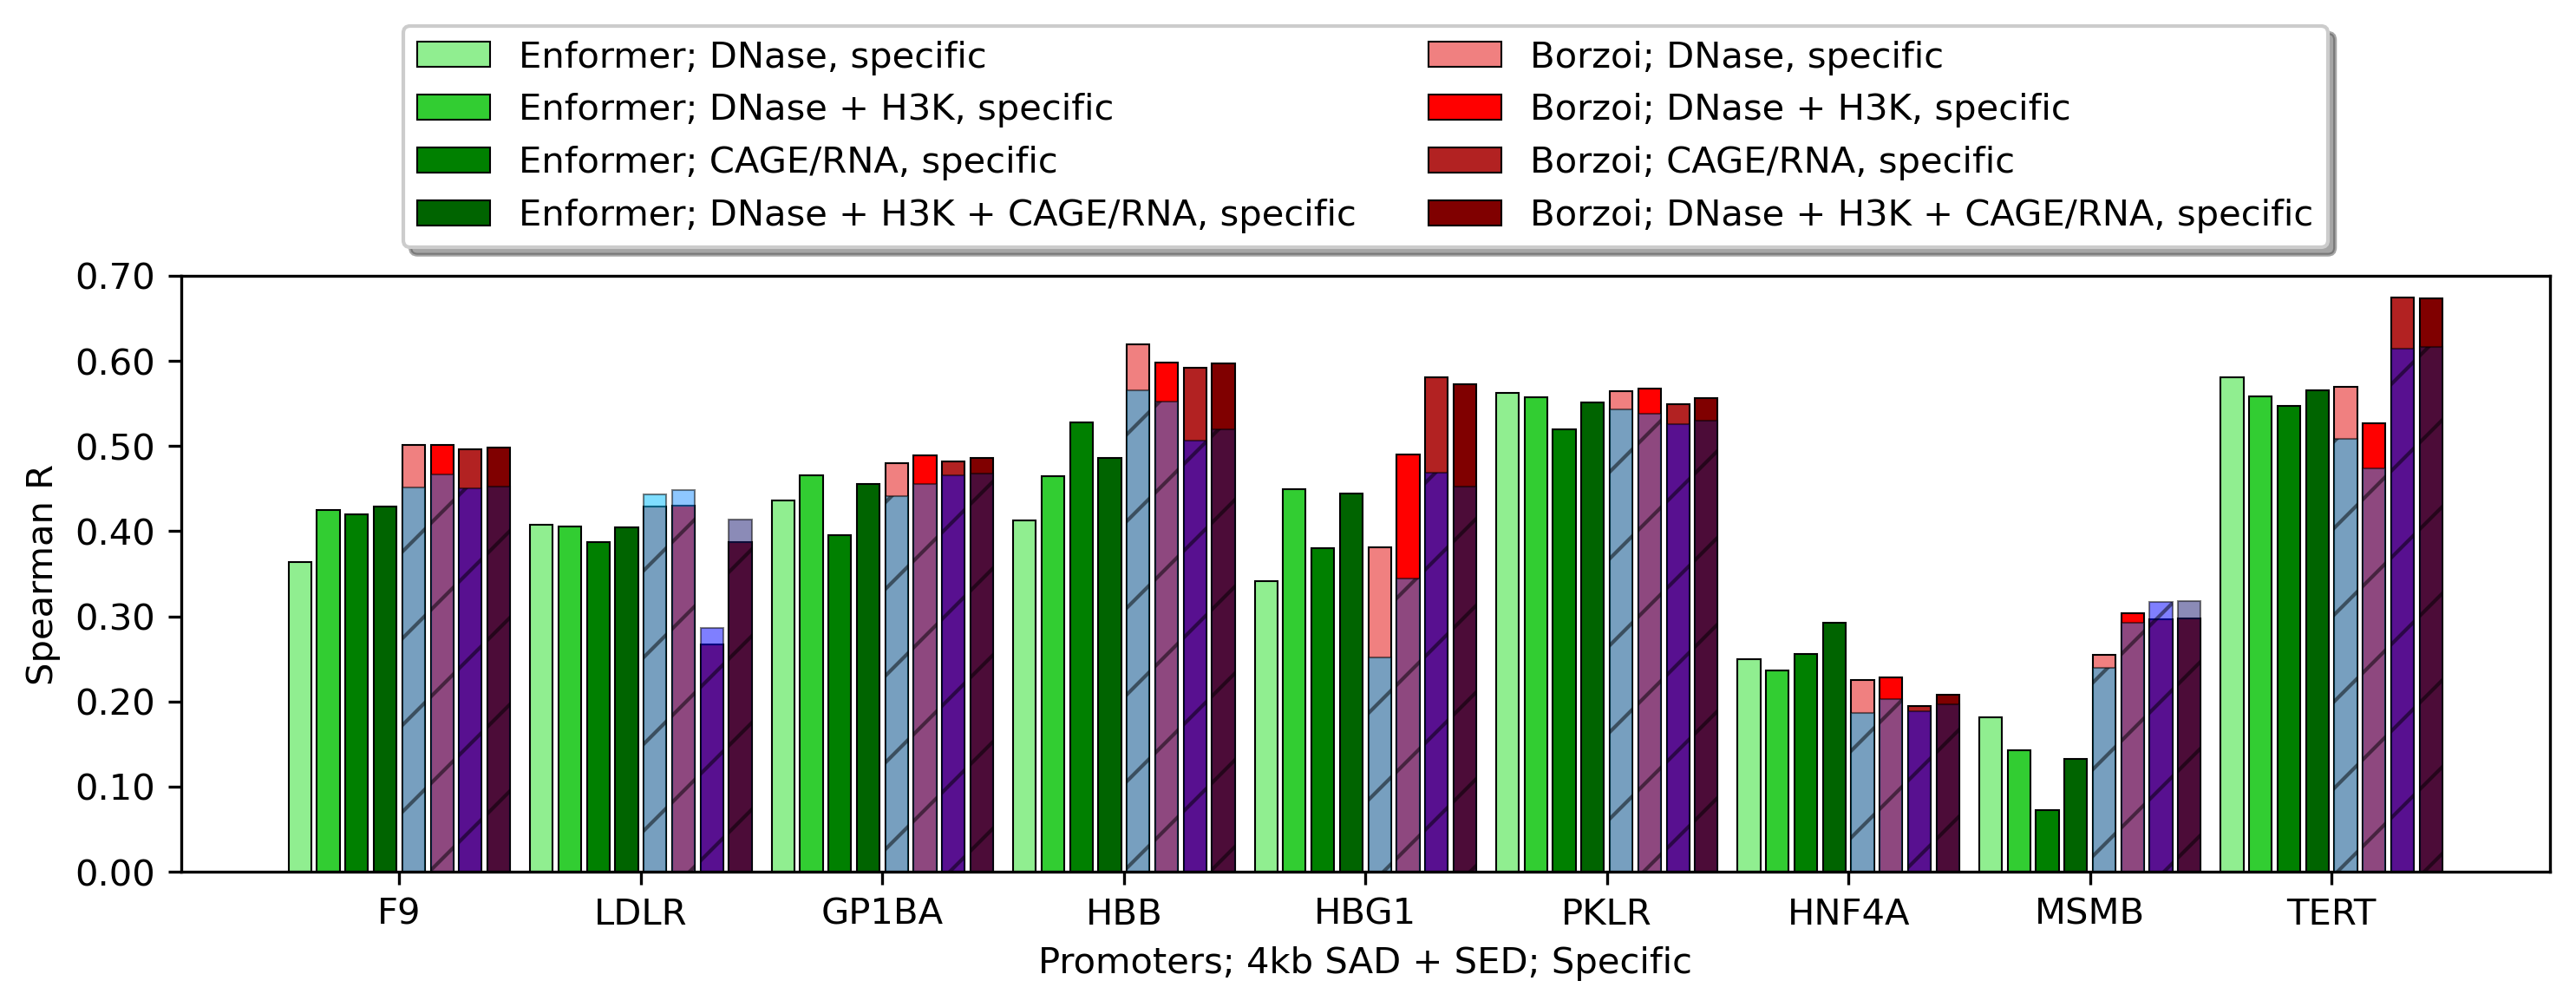

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


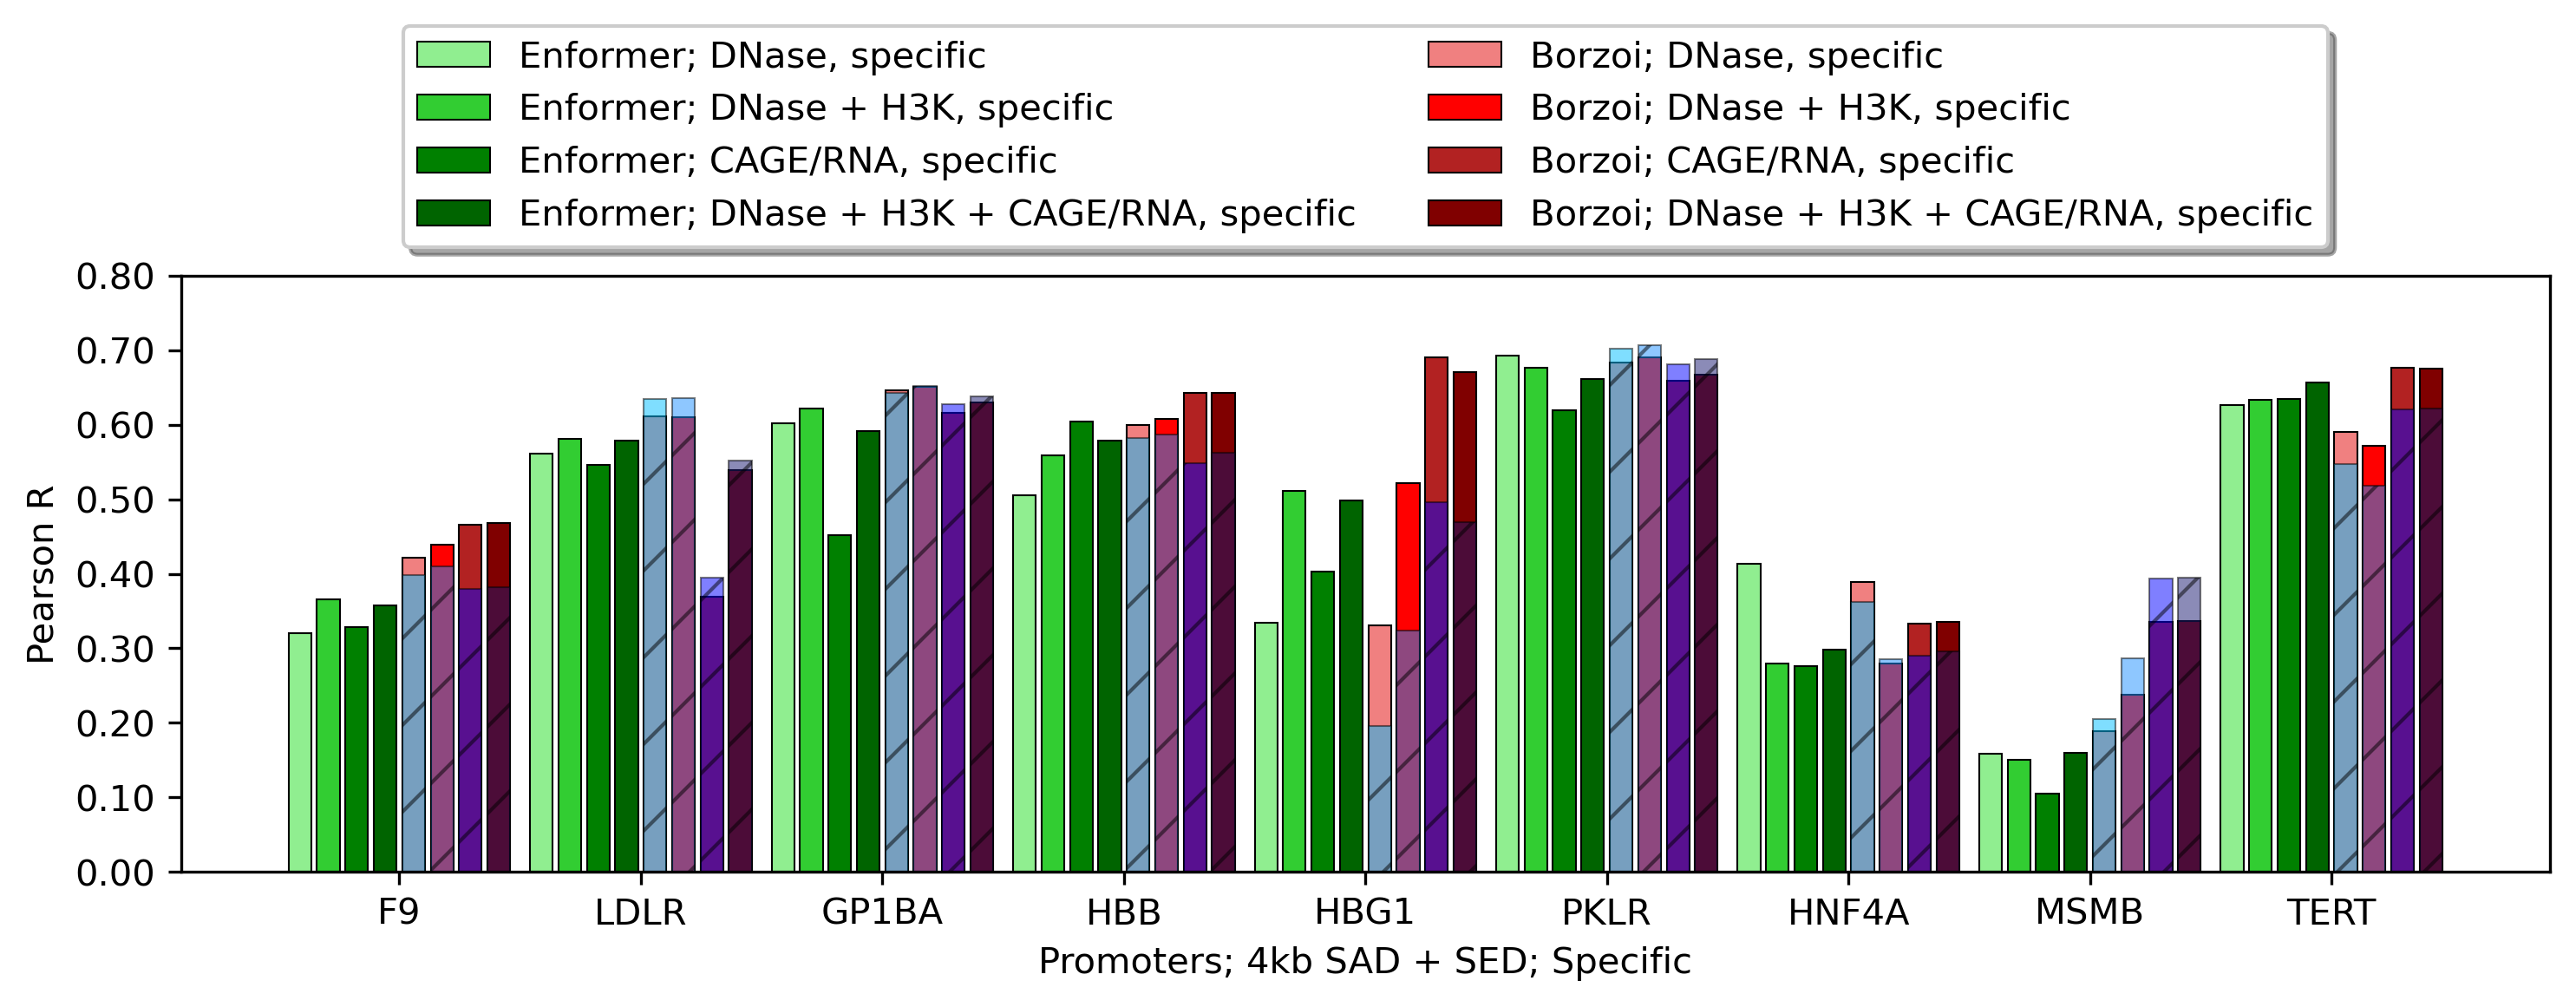

In [8]:
#Evaluate performance (promoters; specific)

plot_title = "Promoters; 4kb SAD + SED; Specific"

save_name = 'satmut_promoters_4k_opt'

subset_index = [0, 1, 3, 4, 5, 6, 7, 8, 9]
data_index = [1, 3, 5, 7]
window_size = '4kb'

model_names = [
    'Enformer',
    'Borzoi',
    'Borzoi (f0)',
]

model_assay_colors = [
    [
        'lightgreen',
        'limegreen',
        'green',
        'darkgreen',
    ],
    [
        'lightcoral',
        'red',
        'firebrick',
        'maroon',
    ],
    [
        'deepskyblue',
        'dodgerblue',
        'blue',
        'midnightblue',
    ],
]

_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'spearman',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.70,
    save_name=save_name + '_spearman',
)
_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'pearson',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.80,
    save_name=save_name + '_pearson',
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


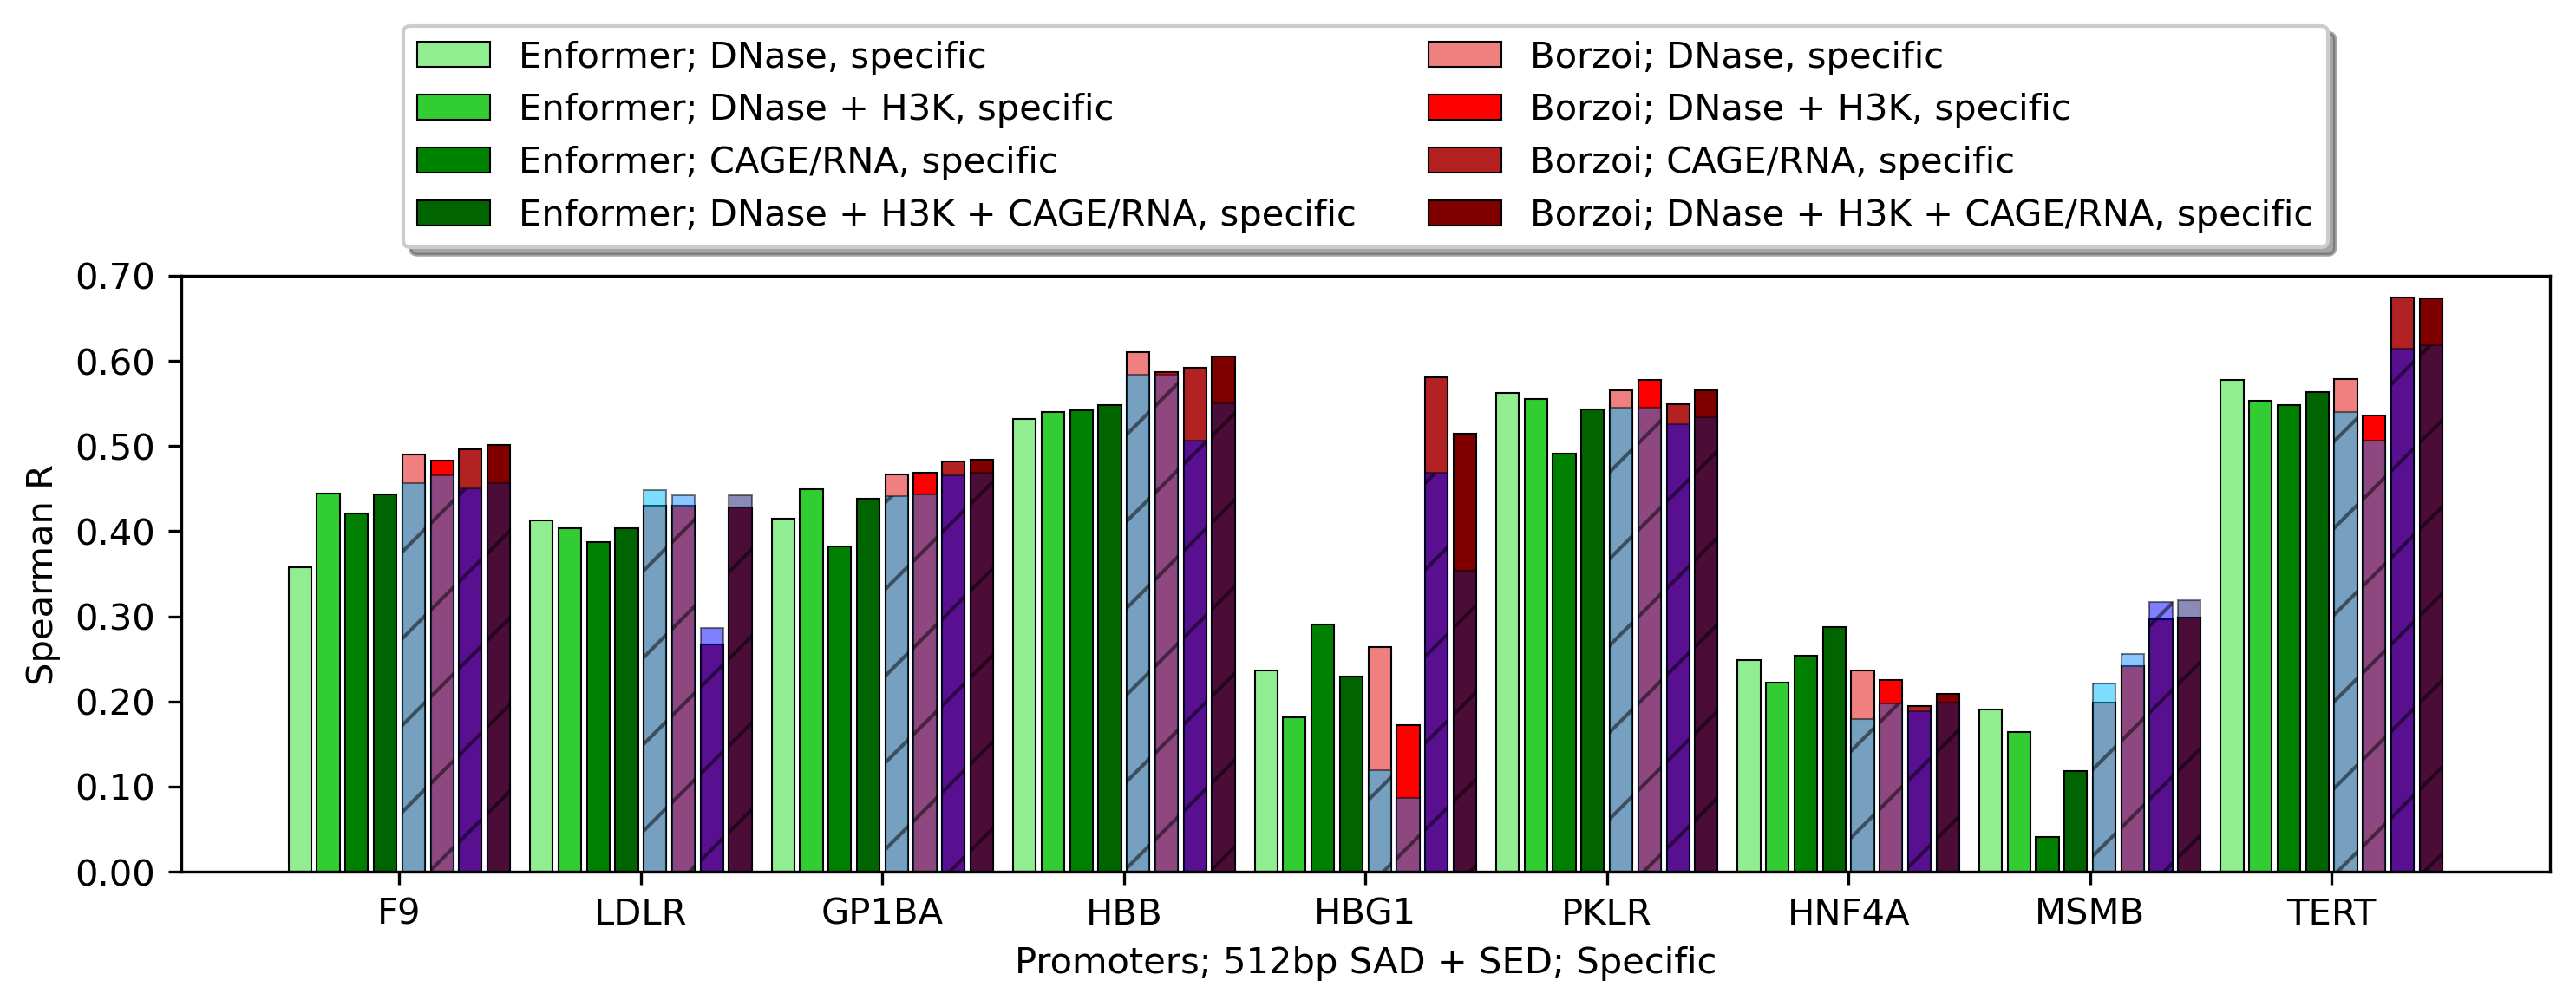

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


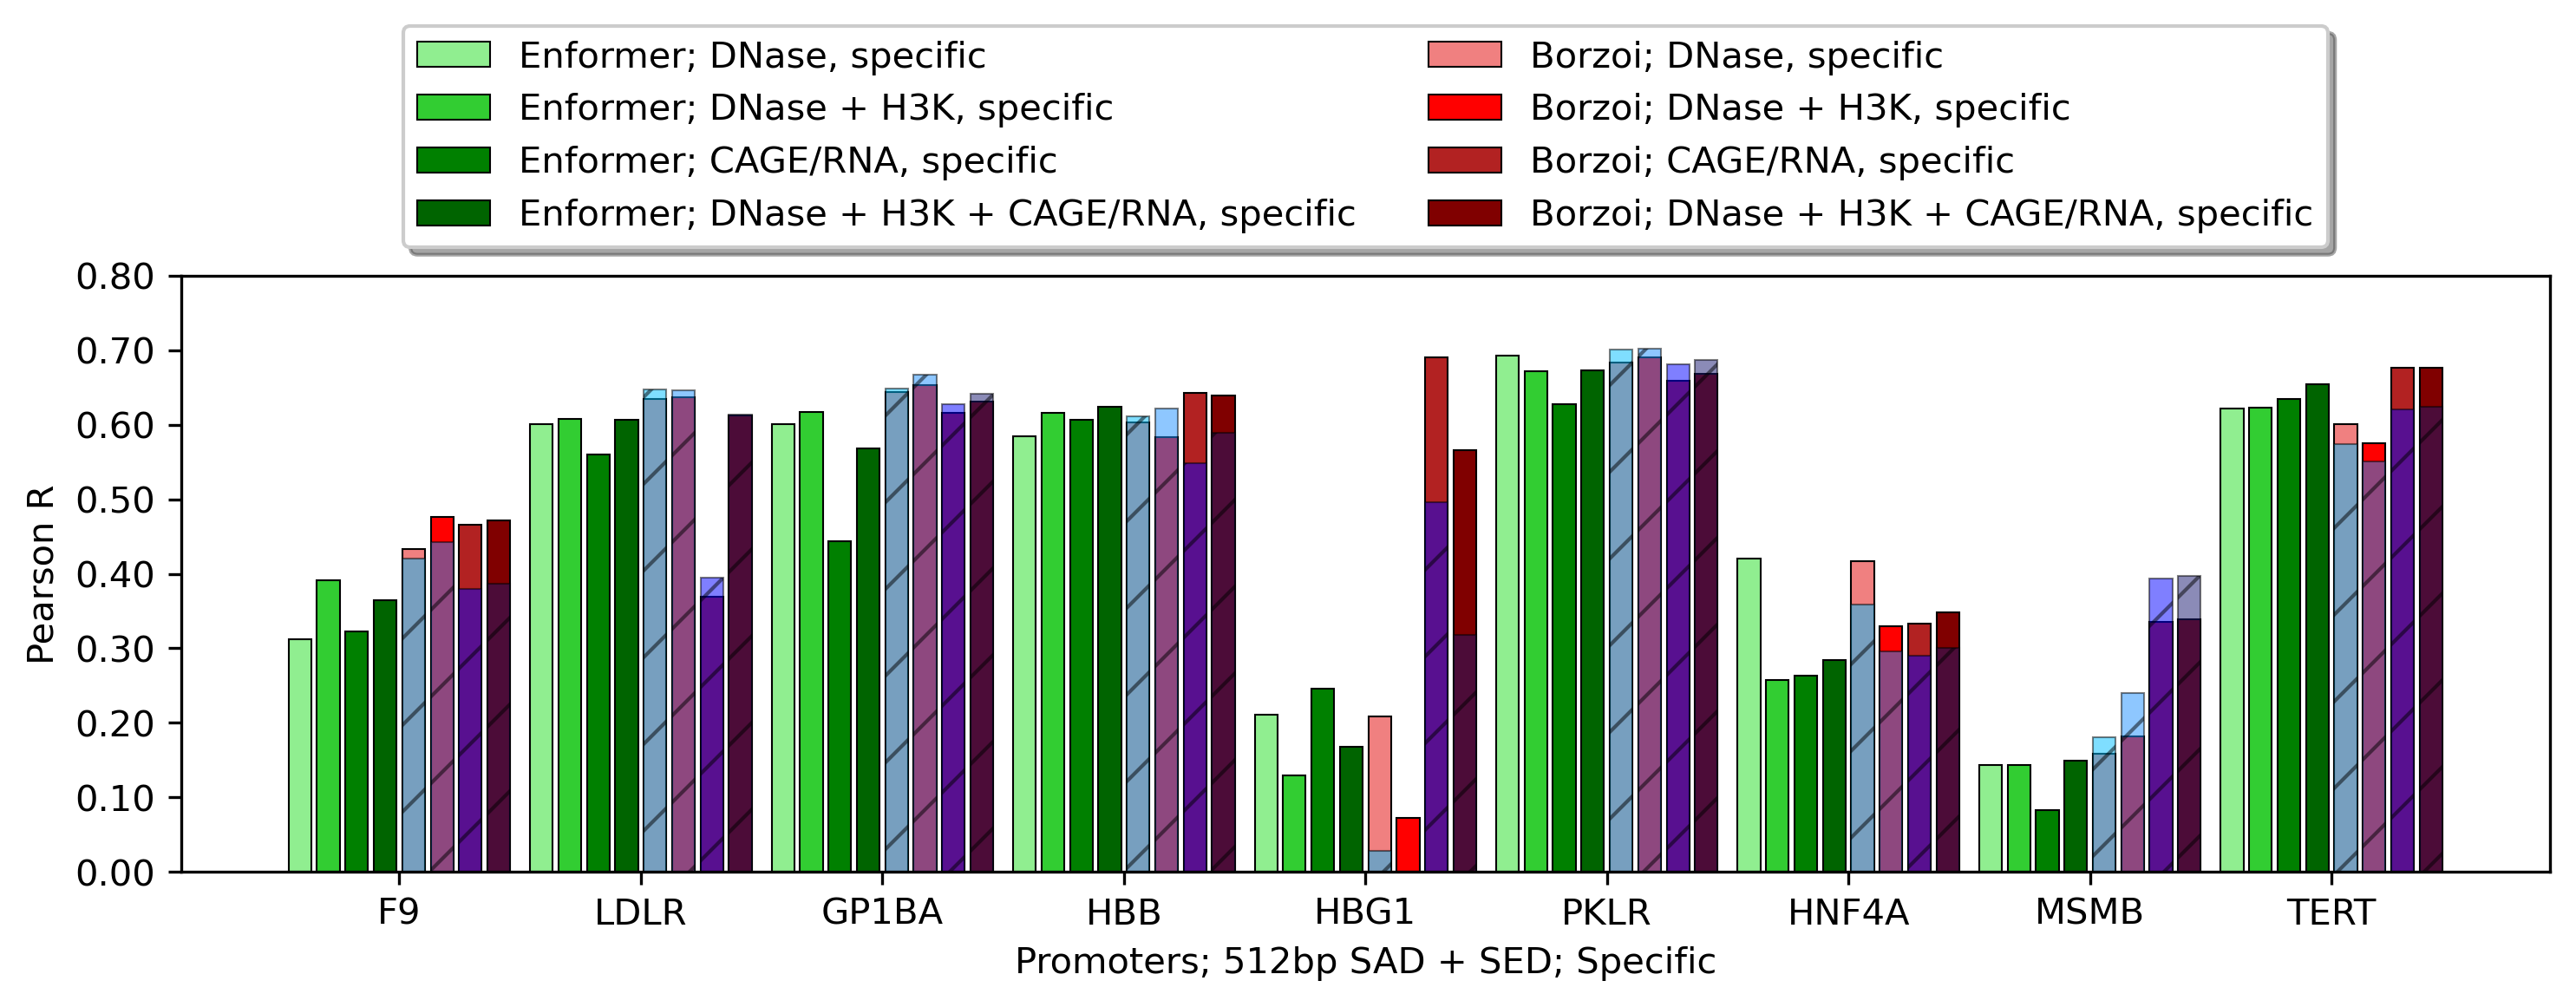

In [9]:
#Evaluate performance (promoters; specific)

plot_title = "Promoters; 512bp SAD + SED; Specific"

save_name = 'satmut_promoters_05k_opt'

subset_index = [0, 1, 3, 4, 5, 6, 7, 8, 9]
data_index = [1, 3, 5, 7]
window_size = '512bp'

model_names = [
    'Enformer',
    'Borzoi',
    'Borzoi (f0)',
]

model_assay_colors = [
    [
        'lightgreen',
        'limegreen',
        'green',
        'darkgreen',
    ],
    [
        'lightcoral',
        'red',
        'firebrick',
        'maroon',
    ],
    [
        'deepskyblue',
        'dodgerblue',
        'blue',
        'midnightblue',
    ],
]

_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'spearman',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.70,
    save_name=save_name + '_spearman',
)
_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'pearson',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.80,
    save_name=save_name + '_pearson',
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


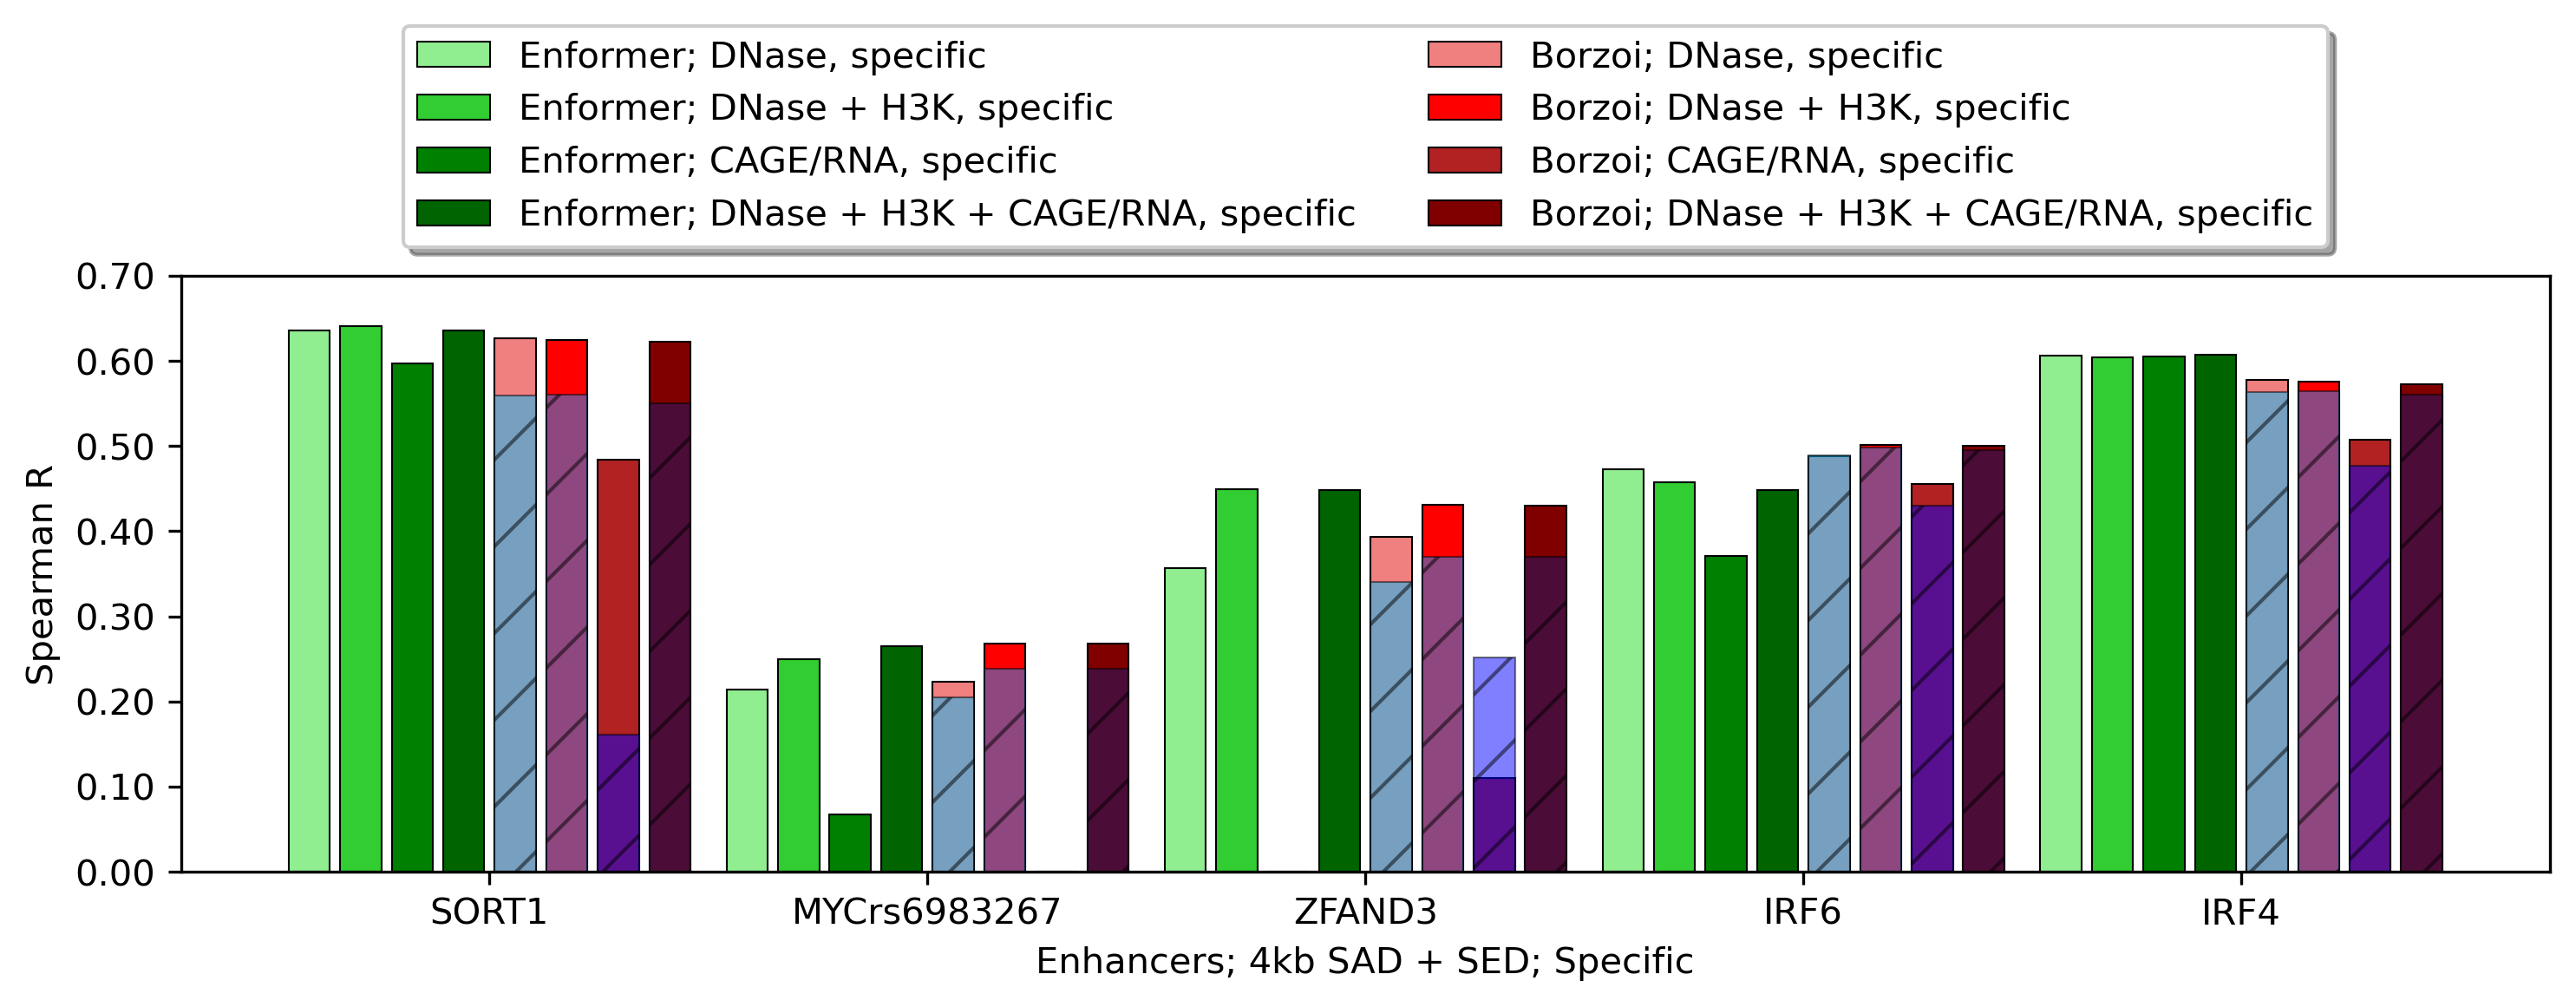

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


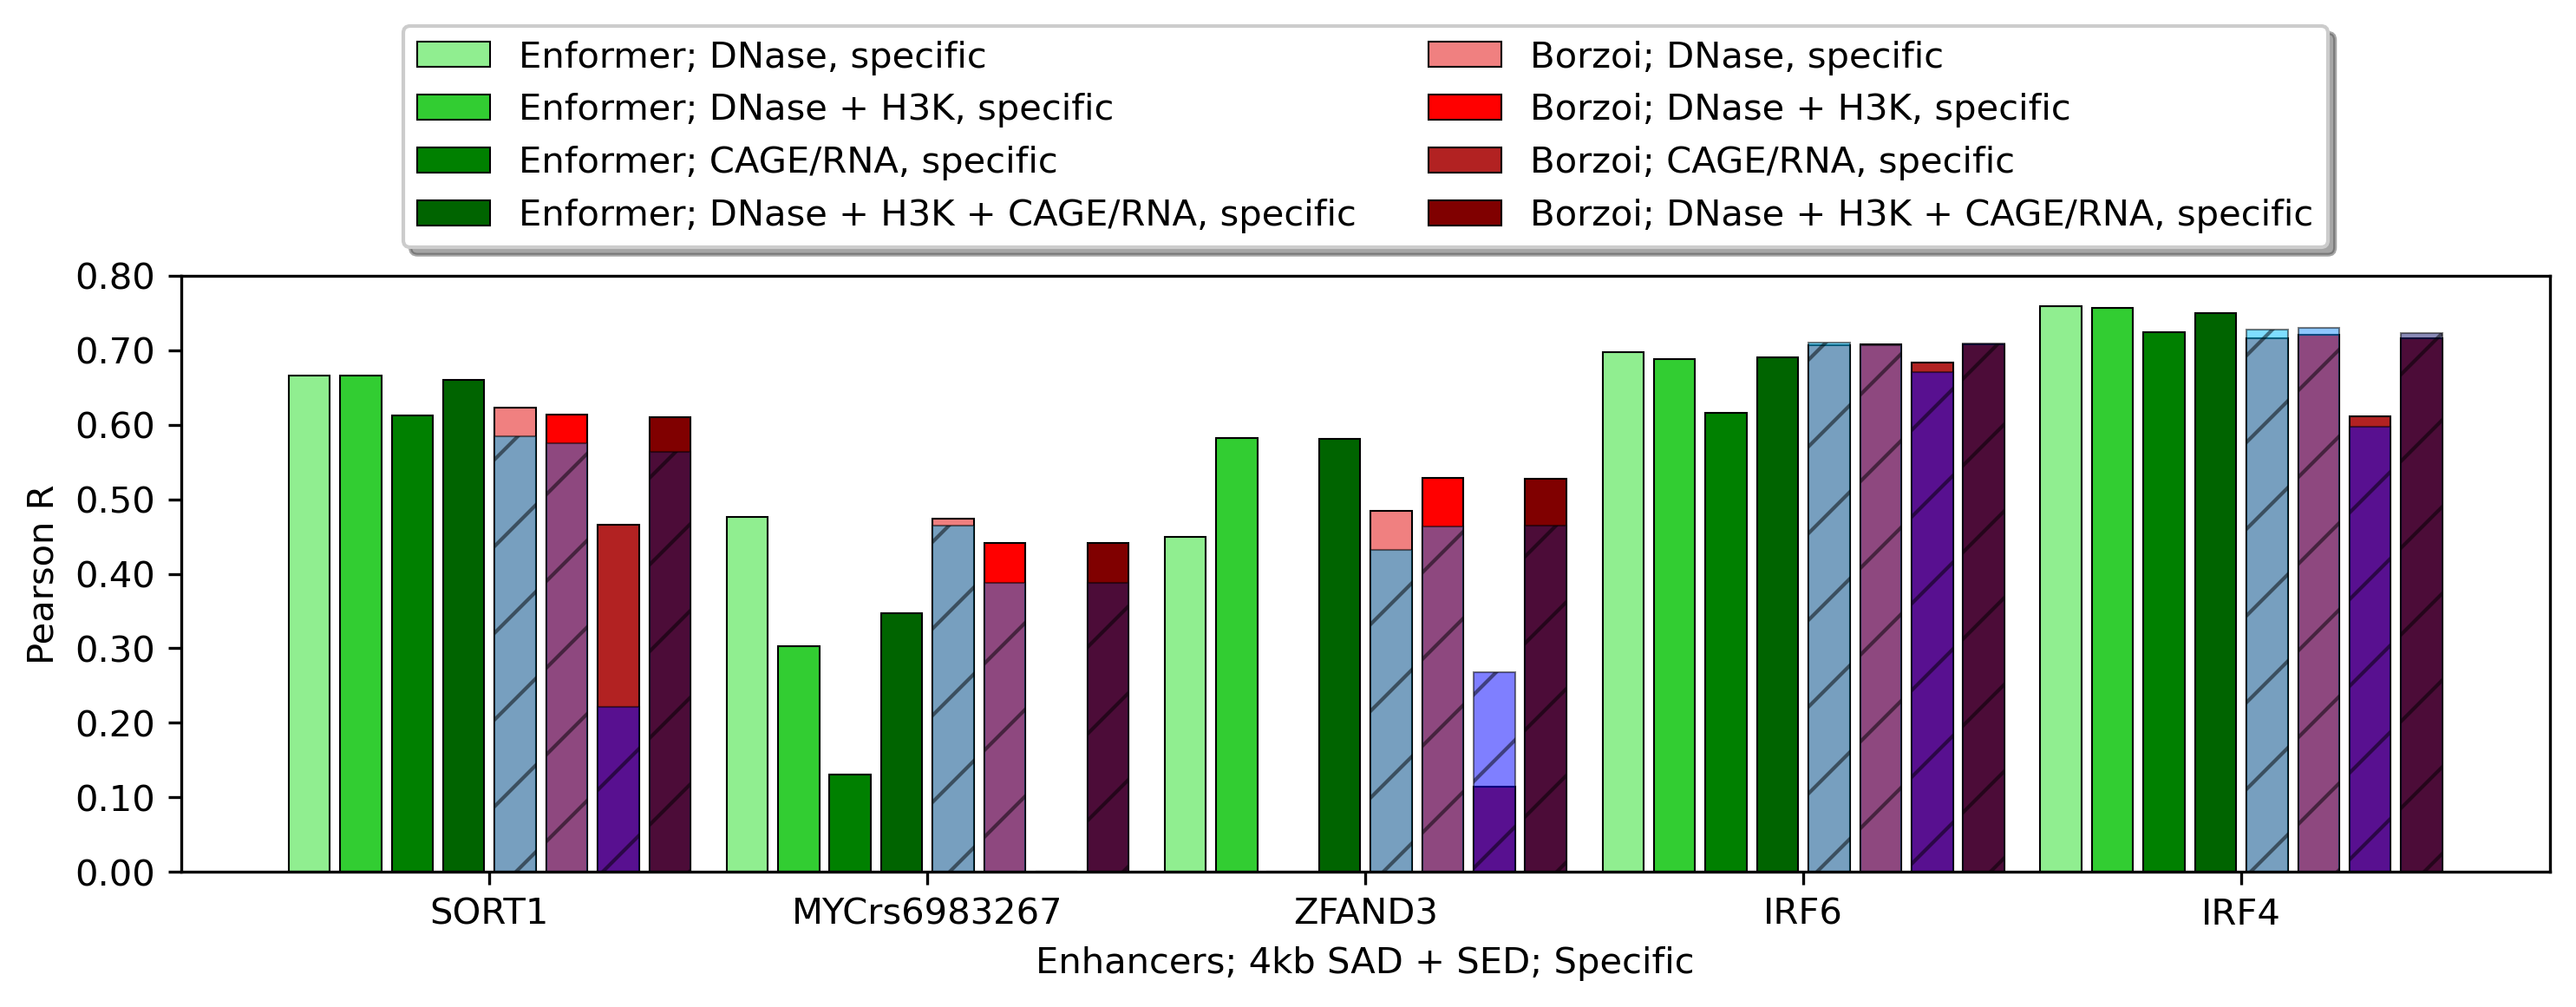

In [10]:
#Evaluate performance (enhancers; specific)

plot_title = "Enhancers; 4kb SAD + SED; Specific"

save_name = 'satmut_enhancers_4k_opt'

subset_index = [2, 10, 11, 12, 13]
data_index = [1, 3, 5, 7]
window_size = '4kb'

model_names = [
    'Enformer',
    'Borzoi',
    'Borzoi (f0)',
]

model_assay_colors = [
    [
        'lightgreen',
        'limegreen',
        'green',
        'darkgreen',
    ],
    [
        'lightcoral',
        'red',
        'firebrick',
        'maroon',
    ],
    [
        'deepskyblue',
        'dodgerblue',
        'blue',
        'midnightblue',
    ],
]

_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'spearman',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.70,
    save_name=save_name + '_spearman',
)
_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'pearson',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.80,
    save_name=save_name + '_pearson',
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


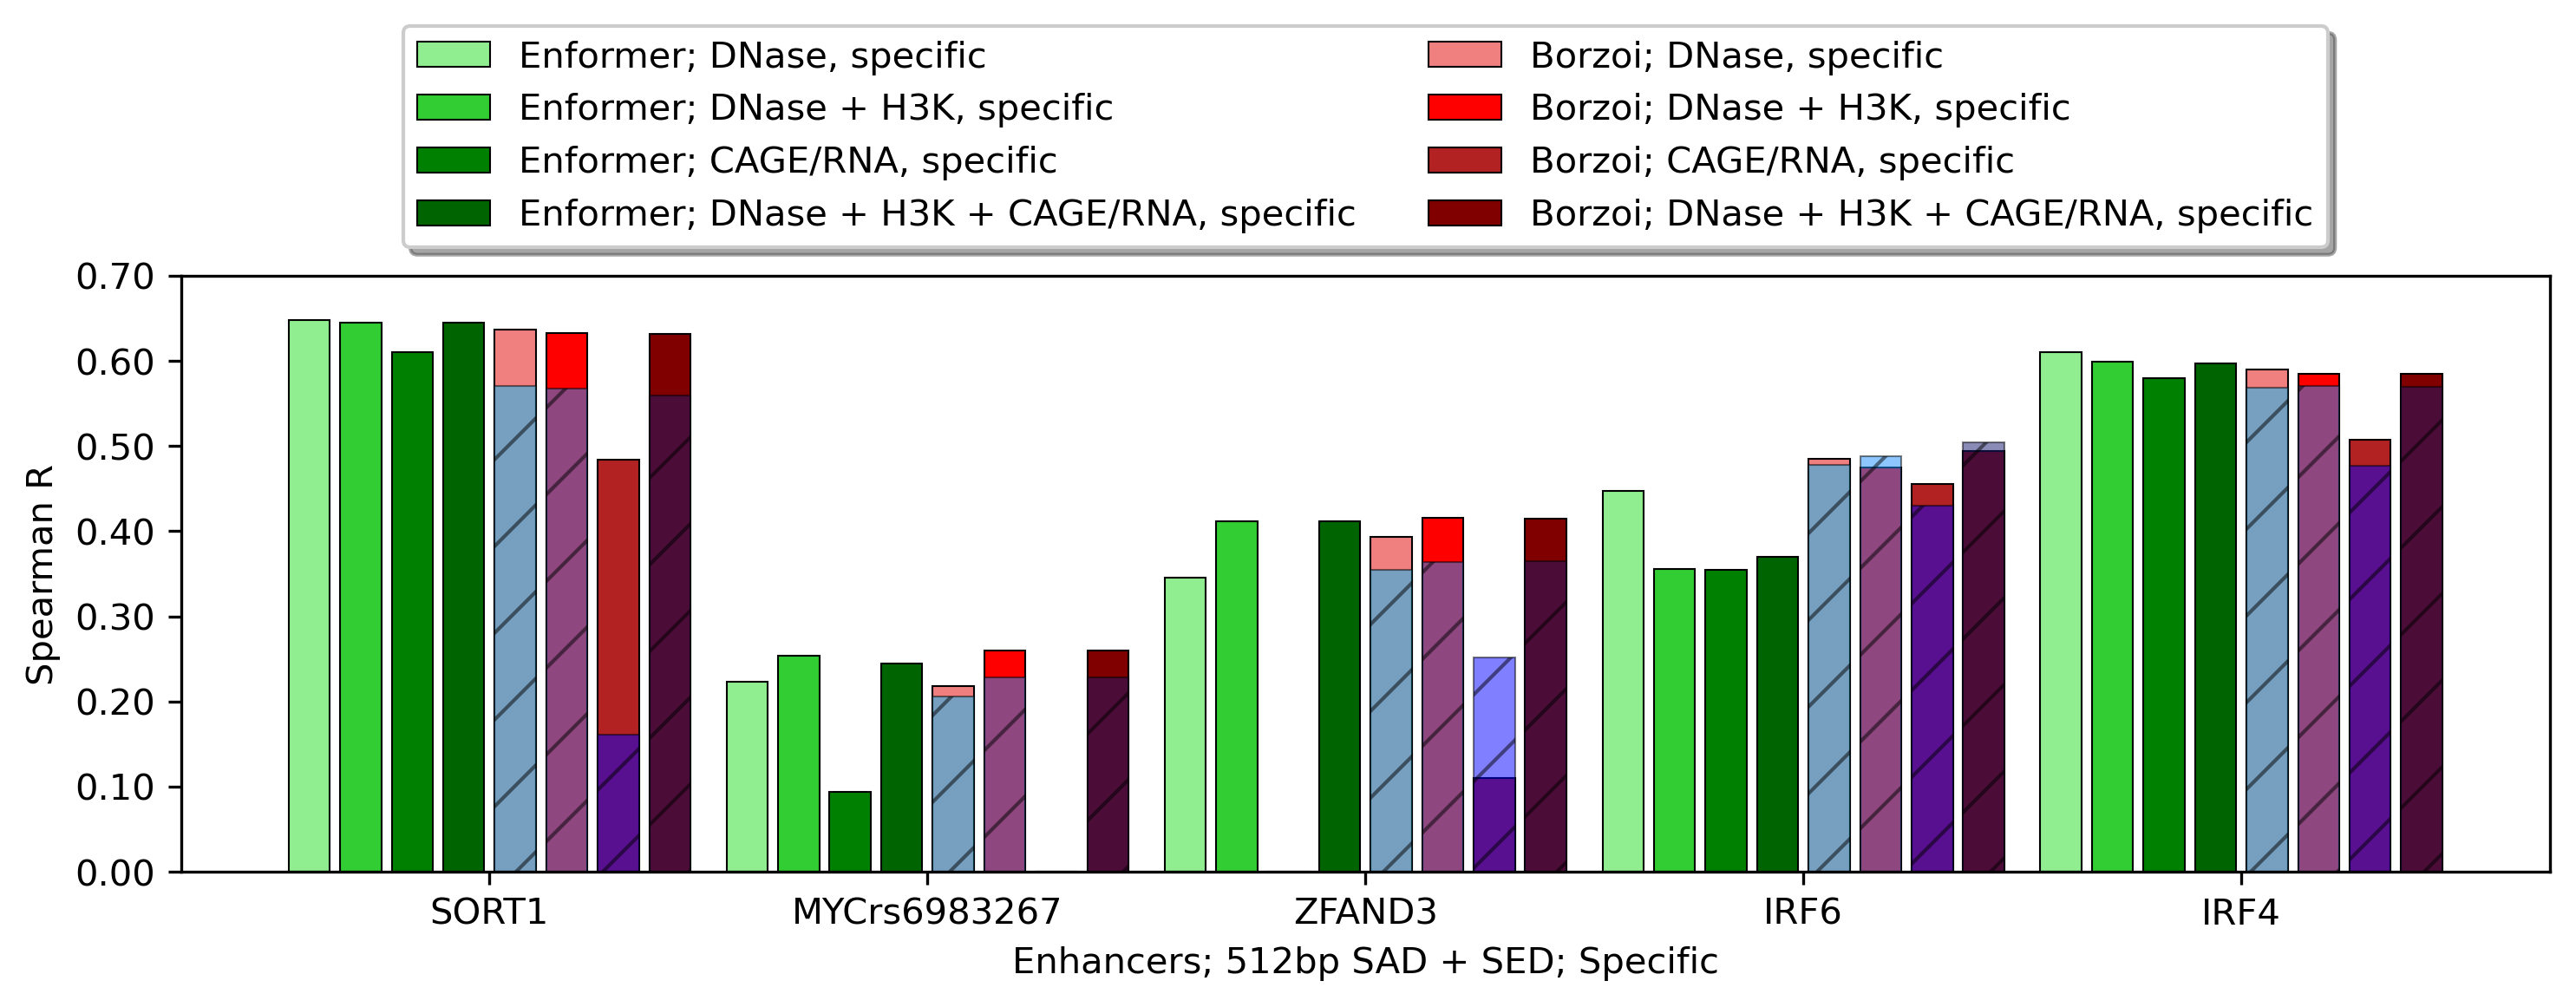

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


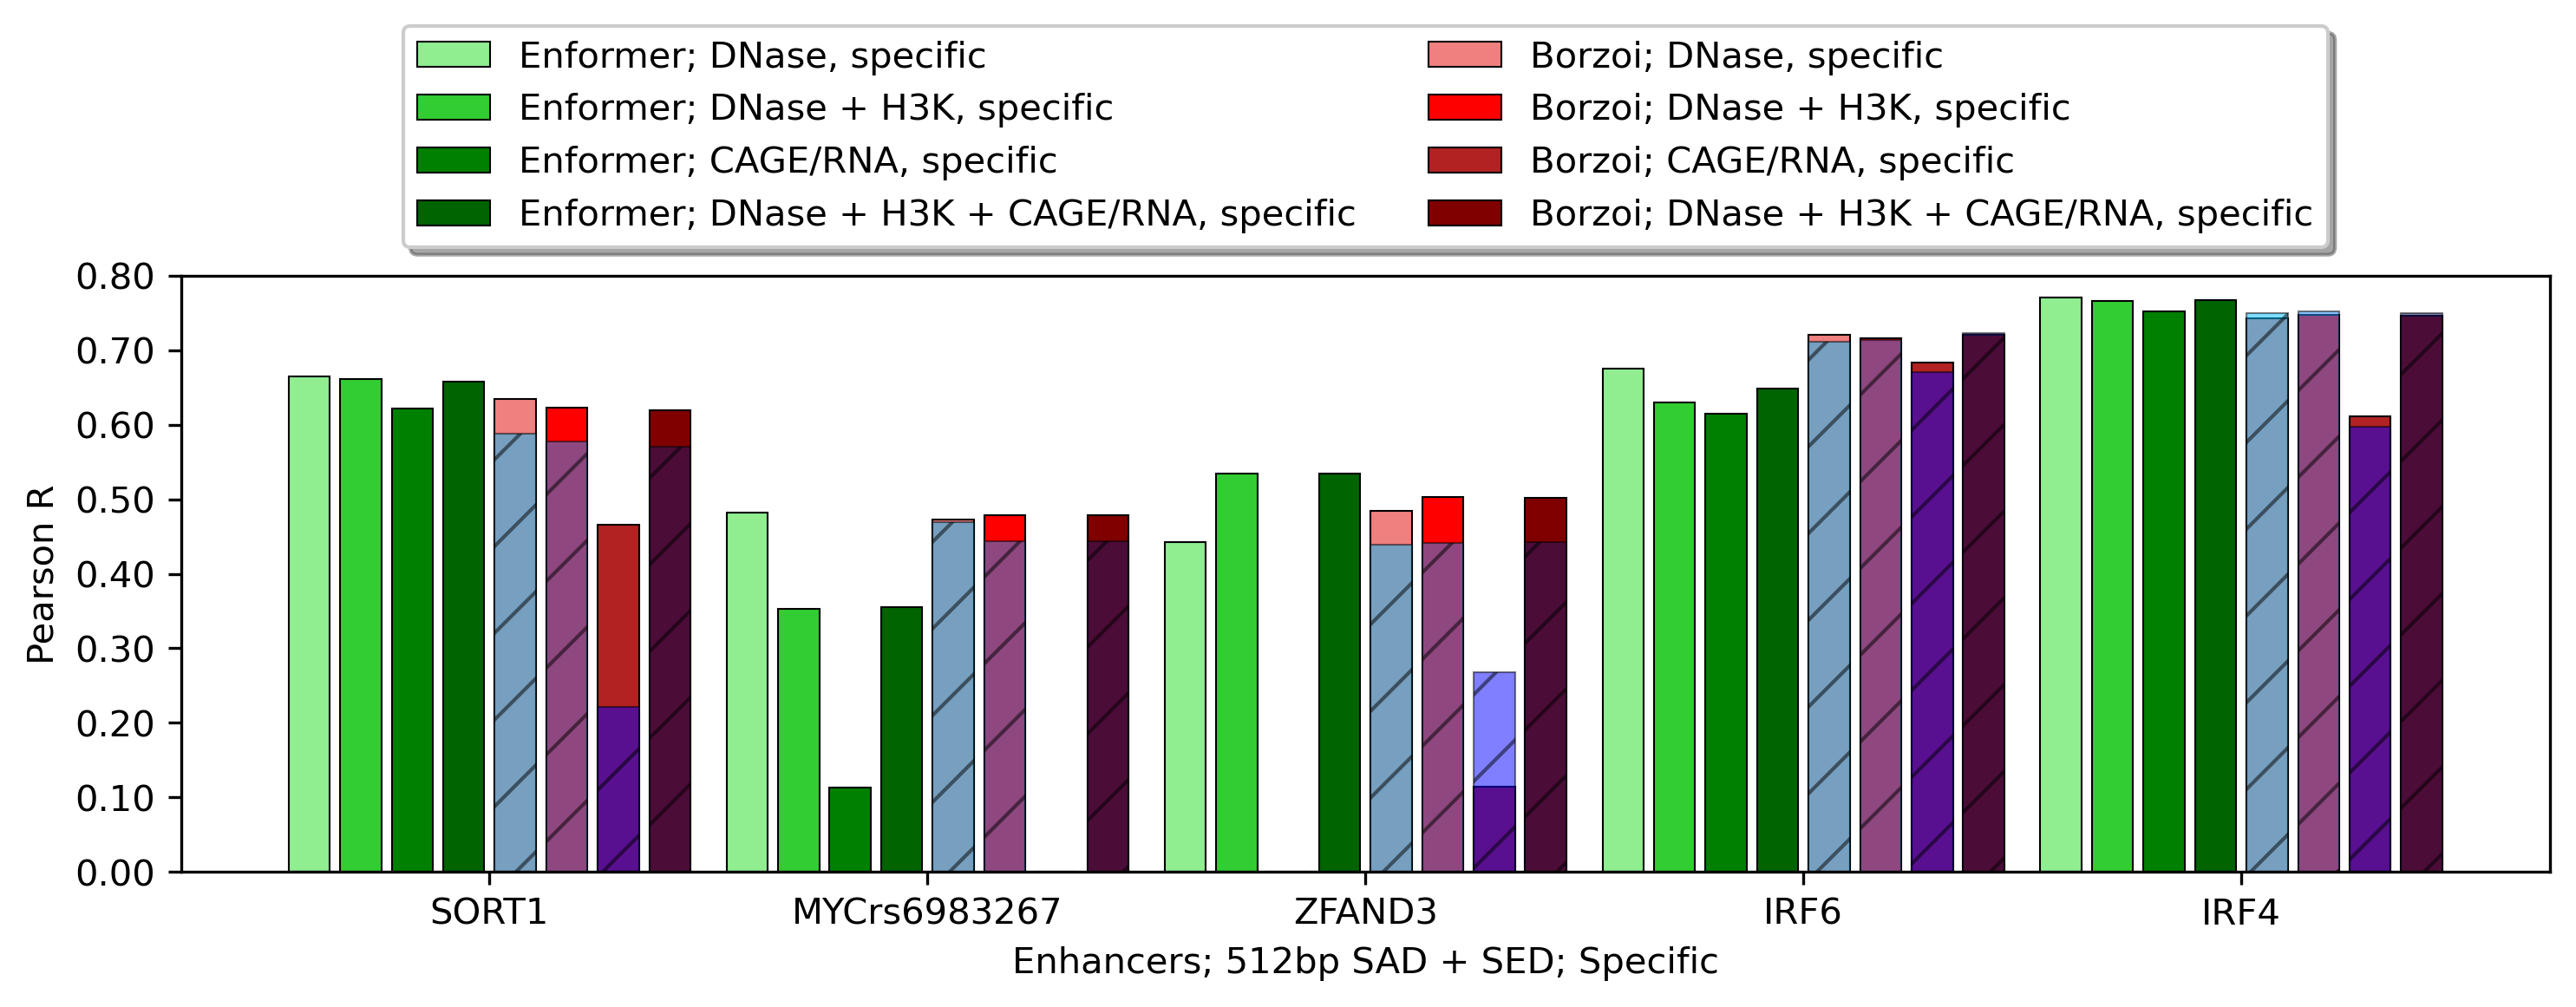

In [12]:
#Evaluate performance (enhancers; specific)

plot_title = "Enhancers; 512bp SAD + SED; Specific"

save_name = 'satmut_enhancers_05k_opt'

subset_index = [2, 10, 11, 12, 13]
data_index = [1, 3, 5, 7]
metric = 'spearman'
window_size = '512bp'

model_names = [
    'Enformer',
    'Borzoi',
    'Borzoi (f0)',
]

model_assay_colors = [
    [
        'lightgreen',
        'limegreen',
        'green',
        'darkgreen',
    ],
    [
        'lightcoral',
        'red',
        'firebrick',
        'maroon',
    ],
    [
        'deepskyblue',
        'dodgerblue',
        'blue',
        'midnightblue',
    ],
]

_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'spearman',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.70,
    save_name=save_name + '_spearman',
)
_plot_bar_chart(
    plot_title,
    subset_index,
    data_index,
    'pearson',
    window_size,
    model_names,
    model_assay_colors,
    bar_hatch=None,
    y_min=0.00,
    y_max=0.80,
    save_name=save_name + '_pearson',
)
